<h1 align=center><font size = 10>Capstone project</font></h1>

<h2> Mario Molina, Aug 2020</h2>

This notebook will be used for the capstone project, in the 'Applied Data Science Capstone' course.
    
In this project we will try to predict the success of a venue, based on its location (neigborhood) and category.
We will be able to make recommendations such as: "The best neighboorhood to place a burguer joint is ..., 
or answer questions like: "If I have a property in X neighborhood, what type of venue would it be better to set up?"


In [1]:
!pip install beautifulsoup4
!pip install lxml
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

print("Everything installed :)")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Everything installed :)


In [2]:
from bs4 import BeautifulSoup # Library for web scraping
import requests               # Library to handle requests
import numpy as np            # library to handle data in a vectorized manner
import pandas as pd           # Library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json # library to handle JSON files
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from IPython.display import display_html

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import seaborn as sns

print("Libraries imported ;)")

Libraries imported ;)


<h2>Part 1: Data preprocessing</h2>

<h3>Reading data</h3>

<h4>Getting data from the Toronto neighborhoods, including postal codes and names</h4>

In [4]:
# Scraping wiki and getting table

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source,'lxml')
print(soup.title)
tab = str(soup.table)
#display_html(tab,raw=True)

<title>List of postal codes of Canada: M - Wikipedia</title>


In [7]:
# Converting table to dataframe

df_tor = pd.read_html(tab)
df_tor = df_tor[0]
#df_tor.head()

In [8]:
# Renaming columns

df_tor = df_tor.rename(columns={'Postal Code': 'PostalCode', 'Neighbourhood':'Neighborhood'})
#df_tor.head()

In [9]:
# Dropping 'Not assigned' boroughs

indexNames = df_tor[ df_tor['Borough'] =='Not assigned'].index
df_tor.drop(indexNames , inplace=True)
#df_tor.head(10)

In [10]:
# Assigning the same name from Borough where Neighborhood is 'Not assigned'

df_tor.loc[df_tor['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df_tor['Borough']
#df_tor.head()

In [11]:
# Resetting index

df_tor.reset_index(inplace=True)
df_tor.drop('index', axis=1, inplace=True)
df_tor.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [66]:
df_tor.shape

(103, 3)

<h4>Getting coordinates for the postal codes, adding them to the neiborhoods dataframe</h4>

In [104]:
# Downloading coordinates for postal codes 

df_coordinates = pd.read_csv('https://cocl.us/Geospatial_data')
#df_coordinates.head()

In [105]:
# Renaming column

df_coordinates = df_coordinates.rename(columns={'Postal Code': 'PostalCode'})
#df_coordinates.shape
#df_coordinates.head()

In [106]:
# Merging the two dataframes

df_neighborhoods = pd.merge(df_tor, df_coordinates, on = 'PostalCode')
df_neighborhoods.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h4>Getting venues and their info for each of the neighborhoods</h4>

In [6]:
#Foursquare credentials 

CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [14]:
# Function to explore venues in each neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Id',          
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Getting the data for toronto venues

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
toronto_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                                   latitudes=df_neighborhoods['Latitude'],
                                   longitudes=df_neighborhoods['Longitude']
                                  )

In [3]:
#Save dataframe to csv to access it quickly rather than running all the previous commands each time (including the Foursquare API requests)
#First 'checkpoint' of the notebook

#toronto_venues.to_csv('toronto_venues.csv')
toronto_venues= pd.read_csv('toronto_venues.csv', index_col=0)

In [108]:
print("Shape of Toronto Venues dataframe: " + str(toronto_venues.shape))
toronto_venues.head()
#toronto_venues.groupby('Neighborhood').count()

Shape of Toronto Venues dataframe: (2146, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,4e8d9dcdd5fbbbb6b3003c7b,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,4cb11e2075ebb60cd1c4caad,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,4c633acb86b6be9a61268e34,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,4f3ecce6e4b0587016b6f30d,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,4bbe904a85fbb713420d7167,43.725517,-79.313103,Coffee Shop


In [7]:
#Function to get the rating for each of the venues in the dataframe, returns a small dataframe of just the venue ID and rating

def get_venues_rating(fq_client, fq_secret, fq_version, dataframe):
    
    venues_id_list=[]
    venues_rating_list=[]
    
    for ven_id in dataframe["Id"]:
        #print(ven_id)
        url = "https://api.foursquare.com/v2/venues/" + ven_id + "?&client_id=" + fq_client + "&client_secret=" + fq_secret+ "&v="+ fq_version
        #print(url)
        try:
            rating = requests.get(url).json()['response']['venue']['rating']
            venues_id_list.append(ven_id)
            venues_rating_list.append(rating)
        except:
            rating = "No rating received for this venue"
            venues_id_list.append(ven_id)
            venues_rating_list.append(rating)
            
    list_of_tuples = list(zip(venues_id_list, venues_rating_list))
    df = pd.DataFrame(list_of_tuples, columns = ['Id', 'Rating'])  
    return df
        

In [20]:
# Split the full dataframe, since the Foursquare API call to get the rating is a premium one, we will need to do this over the course of 5 days

tor_ven1 = toronto_venues [0:490]
tor_ven2 = toronto_venues [490:980]
tor_ven3 = toronto_venues [980:1470]
tor_ven4 = toronto_venues [1470:1960]
tor_ven5 = toronto_venues [1960:]

In [9]:
# Call the function to get the venue rating for each of the split dataframes 

#venues_rating1 = get_venues_rating(CLIENT_ID, CLIENT_SECRET, VERSION, tor_ven1)
#venues_rating2 = get_venues_rating(CLIENT_ID, CLIENT_SECRET, VERSION, tor_ven2)
#venues_rating3 = get_venues_rating(CLIENT_ID, CLIENT_SECRET, VERSION, tor_ven3)
#venues_rating4 = get_venues_rating(CLIENT_ID, CLIENT_SECRET, VERSION, tor_ven4)
#venues_rating5 = get_venues_rating(CLIENT_ID, CLIENT_SECRET, VERSION, tor_ven5)

In [10]:
# Merge the rating dataframe with all other columns

#tor_ven_rating1 = pd.merge(tor_ven1, venues_rating1, on = 'Id')
#tor_ven_rating2 = pd.merge(tor_ven2, venues_rating2, on = 'Id')
#tor_ven_rating3 = pd.merge(tor_ven3, venues_rating3, on = 'Id')
#tor_ven_rating4 = pd.merge(tor_ven4, venues_rating4, on = 'Id')
#tor_ven_rating5 = pd.merge(tor_ven5, venues_rating5, on = 'Id')

In [12]:
#Save each split dataframeto a csv file

#tor_ven_rating1.to_csv('tor_ven_rating1.csv')
#tor_ven_rating2.to_csv('tor_ven_rating2.csv')
#tor_ven_rating3.to_csv('tor_ven_rating3.csv')
#tor_ven_rating4.to_csv('tor_ven_rating4.csv')
#tor_ven_rating5.to_csv('tor_ven_rating5.csv')

In [15]:
#Load the csv files saved over the last five days

#tor_ven_rating1= pd.read_csv('tor_ven_rating1.csv', index_col=0)
#tor_ven_rating2= pd.read_csv('tor_ven_rating2.csv', index_col=0)
#tor_ven_rating3= pd.read_csv('tor_ven_rating3.csv', index_col=0)
#tor_ven_rating4= pd.read_csv('tor_ven_rating4.csv', index_col=0)
#tor_ven_rating5= pd.read_csv('tor_ven_rating5.csv', index_col=0)

In [4]:
#Join the split dataframes again to have the full dataset
#Second 'checkpoint' of the notebook

#toronto_venues = pd.concat([tor_ven_rating1, tor_ven_rating2, tor_ven_rating3, tor_ven_rating4, tor_ven_rating5])
#toronto_venues.to_csv('toronto_ven_rating_full.csv')

toronto_venues= pd.read_csv('toronto_ven_rating_full.csv', index_col=0)

<h3>Now we have our full dataset, let's explore and decide how to continue from there</h3>

In [14]:
print("Shape of Toronto Venues dataframe: " + str(toronto_venues.shape))
#toronto_venues.head()
#toronto_venues.groupby('Neighborhood').count()
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} neighborhoods.'.format(len(toronto_venues['Neighborhood'].unique())))
toronto_venues.head(3)

Shape of Toronto Venues dataframe: (2384, 9)
There are 264 unique categories.
There are 96 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,4e8d9dcdd5fbbbb6b3003c7b,43.751976,-79.332140,Park,6.9
1,Parkwoods,43.753259,-79.329656,Variety Store,4cb11e2075ebb60cd1c4caad,43.751974,-79.333114,Food & Drink Shop,No rating received for this venue
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,4c633acb86b6be9a61268e34,43.723481,-79.315635,Hockey Arena,7.3


<h4>We see we have 96 different neighborhoods and 264 different venue categories.</h4>
<h4>It's gonna be hard to predict the rating of a given unknown venue with such broad ranges.</h4>
<h4>We'll proceed to group the venues by category bins, binning together similar venues. We'll also have to deal with the missing rating values for some of the venues, we will use the mode for the corresponding category  bin</h4>

<h4>Create and divide the venues in bins</h4>

In [15]:
#Bin 1
#Coffee and breakfast
bin1 =  ["Coffee Shop", "Breakfast Spot", "Café", "Smoothie Shop", "Bubble Tea Shop",
         "Tea Room", "Juice Bar", "Bagel Shop", "Donut Shop", "Frozen Yogurt Shop", "Cafeteria"]
#Bin 2
#Sweets and deserts
bin2 = ["Bakery", "Chocolate Shop", "Dessert Shop", "Ice Cream Shop", "Creperie", "Cupcake Shop"]

#Bin 3
#Fast food
bin3 = ["Pizza Place", "Burrito Place", "Fried Chicken Joint", "Sandwich Place",
        "Fast Food Restaurant", "Burger Joint", "Taco Place", "Food Truck",
        "Salad Place", "Food Court",  "Snack Place"]

#Bin 4
#European cuisine restaurants
bin4 = ["Portuguese Restaurant", "French Restaurant", "Mediterranean Restaurant",
        "Italian Restaurant", "Modern European Restaurant", "Greek Restaurant",
        "German Restaurant", "Belgian Restaurant", "Eastern European Restaurant"]

#Bin 5
#Asian cuisine restaurants
bin5 = ["Vietnamese Restaurant", "Sushi Restaurant", "Japanese Restaurant",
        "Asian Restaurant", "Ramen Restaurant", "Thai Restaurant", "Chinese Restaurant",
        "Dim Sum Restaurant", "Poke Place", "Indian Restaurant", "Korean Restaurant",
        "Hakka Restaurant", "Noodle House", "Indonesian Restaurant", "Filipino Restaurant",
        "Dumpling Restaurant", "Taiwanese Restaurant", "Afghan Restaurant"]

#Bin 6
#Latin restaurants
bin6 = ["Mexican Restaurant","Caribbean Restaurant", "Colombian Restaurant", 
        "Brazilian Restaurant", "Latin American Restaurant", "Cuban Restaurant"]

#Bin 7
#Middle eastern and african restaurants
bin7 = ["Middle Eastern Restaurant", "Ethiopian Restaurant", "Moroccan Restaurant",
       "Falafel Restaurant", "Doner Restaurant"]

#Bin 8
#General food & drink, restaurants
bin8 = ["Food & Drink Shop", "Restaurant", "Seafood Restaurant", "Diner", "Steakhouse",
        "New American Restaurant", "Poutine Place", "BBQ Joint", "American Restaurant",
        "Vegetarian / Vegan Restaurant", "Comfort Food Restaurant", "Bistro", 
        "Gluten-free Restaurant", "Cajun / Creole Restaurant", "Molecular Gastronomy Restaurant",
        "Soup Place", "Theme Restaurant", "Wings Joint"]

#Bin 9
#Grocery stores, markets
bin9 = ["Farmers Market", "Beer Store", "Health Food Store", "Wine Shop", "Supermarket",
       "Grocery Store", "Market", "Convenience Store", "Liquor Store", "Fish Market",
       "Cheese Shop", "Gourmet Shop", "Fish & Chips Shop", "Candy Store", "Deli / Bodega",
       "Fruit & Vegetable Store", "Stationery Store", "Butcher", "Organic Grocery"]

#Bin 10
#Entertainment
bin10 = ["Jazz Club", "Aquarium", "Movie Theater", "Indie Movie Theater",  "Gaming Cafe", 
         "Roof Deck", "General Entertainment", "Theater", "Music Venue", "Performing Arts Venue",
         "Opera House"]

#Bin 11
#Nightlife, clubs, bars
bin11 = ["Hookah Bar", "Wine Bar", "Lounge", "Beer Bar", "Irish Pub", "Gay Bar",
         "Nightclub", "Speakeasy", "Bar", "Gastropub", "Brewery", "Pub", 
         "Cocktail Bar", "Sports Bar", "Hotel Bar", "Sake Bar", "Strip Club"]

#Bin 12
#Health and beauty services
bin12= ["Spa", "Cosmetics Shop", "Pharmacy", "Tanning Salon", "Medical Center",
        "Drugstore", "Health & Beauty Service", "Supplement Shop"]

#Bin 13
#Outdoors
bin13 = ["Park", "Lake", "Other Great Outdoors", "River", "Field", "Trail", 
         "Playground", "Beach", "Scenic Lookout", "Garden"]

#Bin 14
#Sport activities
bin14 = ["Gym / Fitness Center", "Yoga Studio",  "Gym", "Baseball Field",
         "Soccer Field", "Golf Course", "Dog Run", "Skating Rink", "Curling Ice",
         "Pool", "Climbing Gym", "Swim School", "Tennis Court", 
         "Dance Studio", "Martial Arts Dojo", "Skate Park"]

#Bin 15
#Sport and event venues
bin15 = ["Hockey Arena", "Basketball Stadium", "Baseball Stadium", "Stadium",
         "Convention Center", "Building", "Event Space", "Concert Hall"]

#Bin 16
#Historic landmarks, sites, galleries, museums
bin16 = ["Historic Site", "Art Gallery", "Art Museum", "Fountain", "Museum", 
         "Monument / Landmark", "History Museum", "Sculpture Garden", "Garden Center"]

#Bin 17
#Department stores and shops
bin17 = ["Shoe Store", "Electronics Store", "Furniture / Home Store", "Clothing Store",
         "Hobby Shop", "Antique Shop", "Boutique", "Accessories Store", "Women's Store",
         "Athletics & Sports", "Miscellaneous Shop", "Arts & Crafts Store",
         "Shopping Mall", "Department Store", "Bookstore", "Pet Store", "Comic Shop",
         "Sporting Goods Shop", "Toy / Game Store", "Lingerie Store", "Jewelry Store",
         "Discount Store", "Bike Shop", "Camera Store", "Baby Store", "Bridal Shop",
         "Mobile Phone Shop", "Warehouse Store", "Smoke Shop", "Gift Shop", "Video Game Store",
         "Luggage Store", "Record Shop", "Men's Store", "Flea Market", "Thrift / Vintage Store",
         "Optical Shop", "Hardware Store"]

#Bin18
#Transportation
bin18 = ["Intersection", "Metro Station", "Rental Car Location", "Gas Station", 
         "General Travel", "Bus Station", "Train Station", "Bus Line", "Light Rail Station",
         "Auto Garage",  "Harbor / Marina", "Boat or Ferry"]

#Bin 19
#Other services and businesses
bin19 = ["Distribution Center", "Bank", "Hotel", "Plaza", "Office", "Salon / Barbershop", 
         "Tailor Shop", "Business Service", "Motel", "Massage Studio", "IT Services",
         "Construction & Landscaping", "Coworking Space",  "Lawyer", "Hospital", "Church", 
         "Bed & Breakfast", "Auto Workshop", "Neighborhood", "Recording Studio"] 


#Bin20
#College district
bin20 =  ["College Cafeteria", "College Rec Center", "College Auditorium", "College Stadium",
          "College Arts Building", "College Gym"]

#Bin21
#Airport
bin21 = ["Airport Service", "Airport", "Airport Lounge", "Plane", "Airport Terminal", "Airport Food Court"]

In [16]:
#Function to categorize venues into bins
def bin_venues(row):
    if row["Venue Category"] in bin1:
        return "Bin 1"
    if row["Venue Category"] in bin2:
        return "Bin 2"
    if row["Venue Category"] in bin3:
        return "Bin 3"
    if row["Venue Category"] in bin4:
        return "Bin 4"
    if row["Venue Category"] in bin5:
        return "Bin 5"
    if row["Venue Category"] in bin6:
        return "Bin 6"
    if row["Venue Category"] in bin7:
        return "Bin 7"
    if row["Venue Category"] in bin8:
        return "Bin 8"
    if row["Venue Category"] in bin9:
        return "Bin 9"
    if row["Venue Category"] in bin10:
        return "Bin 10"
    if row["Venue Category"] in bin11:
        return "Bin 11"
    if row["Venue Category"] in bin12:
        return "Bin 12"
    if row["Venue Category"] in bin13:
        return "Bin 13"
    if row["Venue Category"] in bin14:
        return "Bin 14"
    if row["Venue Category"] in bin15:
        return "Bin 15"
    if row["Venue Category"] in bin16:
        return "Bin 16"
    if row["Venue Category"] in bin17:
        return "Bin 17"
    if row["Venue Category"] in bin18:
        return "Bin 18"
    if row["Venue Category"] in bin19:
        return "Bin 19"
    if row["Venue Category"] in bin20:
        return "Bin 20"
    if row["Venue Category"] in bin21:
        return "Bin 21"
    

In [17]:
toronto_venues['Category Bin'] = toronto_venues.apply(lambda row: bin_venues(row), axis=1)

<h4>To deal with missing rating values, we will use the mode (most common value) for the corresponding category bin</h4>

In [18]:
#Separate each of the bins into their own dataframe
toronto_venues_bin1 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 1"].copy()
toronto_venues_bin2 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 2"].copy()
toronto_venues_bin3 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 3"].copy()
toronto_venues_bin4 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 4"].copy()
toronto_venues_bin5 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 5"].copy()
toronto_venues_bin6 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 6"].copy()
toronto_venues_bin7 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 7"].copy()
toronto_venues_bin8 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 8"].copy()
toronto_venues_bin9 = toronto_venues.loc[toronto_venues["Category Bin"]  == "Bin 9"].copy()
toronto_venues_bin10 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 10"].copy()
toronto_venues_bin11 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 11"].copy()
toronto_venues_bin12 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 12"].copy()
toronto_venues_bin13 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 13"].copy()
toronto_venues_bin14 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 14"].copy()
toronto_venues_bin15 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 15"].copy()
toronto_venues_bin16 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 16"].copy()
toronto_venues_bin17 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 17"].copy()
toronto_venues_bin18 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 18"].copy()
toronto_venues_bin19 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 19"].copy()
toronto_venues_bin20 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 20"].copy()
toronto_venues_bin21 = toronto_venues.loc[toronto_venues["Category Bin"] == "Bin 21"].copy()

In [19]:
#Dropping the rows with no rating
index_no_rating1  = toronto_venues_bin1[toronto_venues_bin1["Rating"]   == "No rating received for this venue" ].index
index_no_rating2  = toronto_venues_bin2[toronto_venues_bin2["Rating"]   == "No rating received for this venue" ].index
index_no_rating3  = toronto_venues_bin3[toronto_venues_bin3["Rating"]   == "No rating received for this venue" ].index
index_no_rating4  = toronto_venues_bin4[toronto_venues_bin4["Rating"]   == "No rating received for this venue" ].index
index_no_rating5  = toronto_venues_bin5[toronto_venues_bin5["Rating"]   == "No rating received for this venue" ].index
index_no_rating6  = toronto_venues_bin6[toronto_venues_bin6["Rating"]   == "No rating received for this venue" ].index
index_no_rating7  = toronto_venues_bin7[toronto_venues_bin7["Rating"]   == "No rating received for this venue" ].index
index_no_rating8  = toronto_venues_bin8[toronto_venues_bin8["Rating"]   == "No rating received for this venue" ].index
index_no_rating9  = toronto_venues_bin9[toronto_venues_bin9["Rating"]   == "No rating received for this venue" ].index
index_no_rating10 = toronto_venues_bin10[toronto_venues_bin10["Rating"] == "No rating received for this venue" ].index
index_no_rating11 = toronto_venues_bin11[toronto_venues_bin11["Rating"] == "No rating received for this venue" ].index
index_no_rating12 = toronto_venues_bin12[toronto_venues_bin12["Rating"] == "No rating received for this venue" ].index
index_no_rating13 = toronto_venues_bin13[toronto_venues_bin13["Rating"] == "No rating received for this venue" ].index
index_no_rating14 = toronto_venues_bin14[toronto_venues_bin14["Rating"] == "No rating received for this venue" ].index
index_no_rating15 = toronto_venues_bin15[toronto_venues_bin15["Rating"] == "No rating received for this venue" ].index
index_no_rating16 = toronto_venues_bin16[toronto_venues_bin16["Rating"] == "No rating received for this venue" ].index
index_no_rating17 = toronto_venues_bin17[toronto_venues_bin17["Rating"] == "No rating received for this venue" ].index
index_no_rating18 = toronto_venues_bin18[toronto_venues_bin18["Rating"] == "No rating received for this venue" ].index
index_no_rating19 = toronto_venues_bin19[toronto_venues_bin19["Rating"] == "No rating received for this venue" ].index
index_no_rating20 = toronto_venues_bin20[toronto_venues_bin20["Rating"] == "No rating received for this venue" ].index
index_no_rating21 = toronto_venues_bin21[toronto_venues_bin21["Rating"] == "No rating received for this venue" ].index


toronto_venues_bin1.drop(index_no_rating1, inplace=True)
toronto_venues_bin2.drop(index_no_rating2, inplace=True)
toronto_venues_bin3.drop(index_no_rating3, inplace=True)
toronto_venues_bin4.drop(index_no_rating4, inplace=True)
toronto_venues_bin5.drop(index_no_rating5, inplace=True)
toronto_venues_bin6.drop(index_no_rating6, inplace=True)
toronto_venues_bin7.drop(index_no_rating7, inplace=True)
toronto_venues_bin8.drop(index_no_rating8, inplace=True)
toronto_venues_bin9.drop(index_no_rating9, inplace=True)
toronto_venues_bin10.drop(index_no_rating10, inplace=True)
toronto_venues_bin11.drop(index_no_rating11, inplace=True)
toronto_venues_bin12.drop(index_no_rating12, inplace=True)
toronto_venues_bin13.drop(index_no_rating13, inplace=True)
toronto_venues_bin14.drop(index_no_rating14, inplace=True)
toronto_venues_bin15.drop(index_no_rating15, inplace=True)
toronto_venues_bin16.drop(index_no_rating16, inplace=True)
toronto_venues_bin17.drop(index_no_rating17, inplace=True)
toronto_venues_bin18.drop(index_no_rating18, inplace=True)
toronto_venues_bin19.drop(index_no_rating19, inplace=True)
toronto_venues_bin20.drop(index_no_rating20, inplace=True)
toronto_venues_bin21.drop(index_no_rating21, inplace=True)

In [20]:
#Ensure data types for the rating column, to get our mode on each bin
toronto_venues_bin1[["Rating"]]  = toronto_venues_bin1[["Rating"]].astype("float")
toronto_venues_bin2[["Rating"]]  = toronto_venues_bin2[["Rating"]].astype("float")
toronto_venues_bin3[["Rating"]]  = toronto_venues_bin3[["Rating"]].astype("float")
toronto_venues_bin4[["Rating"]]  = toronto_venues_bin4[["Rating"]].astype("float")
toronto_venues_bin5[["Rating"]]  = toronto_venues_bin5[["Rating"]].astype("float")
toronto_venues_bin6[["Rating"]]  = toronto_venues_bin6[["Rating"]].astype("float")
toronto_venues_bin7[["Rating"]]  = toronto_venues_bin7[["Rating"]].astype("float")
toronto_venues_bin8[["Rating"]]  = toronto_venues_bin8[["Rating"]].astype("float")
toronto_venues_bin9[["Rating"]]  = toronto_venues_bin9[["Rating"]].astype("float")
toronto_venues_bin10[["Rating"]] = toronto_venues_bin10[["Rating"]].astype("float")
toronto_venues_bin11[["Rating"]] = toronto_venues_bin11[["Rating"]].astype("float")
toronto_venues_bin12[["Rating"]] = toronto_venues_bin12[["Rating"]].astype("float")
toronto_venues_bin13[["Rating"]] = toronto_venues_bin13[["Rating"]].astype("float")
toronto_venues_bin14[["Rating"]] = toronto_venues_bin14[["Rating"]].astype("float")
toronto_venues_bin15[["Rating"]] = toronto_venues_bin15[["Rating"]].astype("float")
toronto_venues_bin16[["Rating"]] = toronto_venues_bin16[["Rating"]].astype("float")
toronto_venues_bin17[["Rating"]] = toronto_venues_bin17[["Rating"]].astype("float")
toronto_venues_bin18[["Rating"]] = toronto_venues_bin18[["Rating"]].astype("float")
toronto_venues_bin19[["Rating"]] = toronto_venues_bin19[["Rating"]].astype("float")
toronto_venues_bin20[["Rating"]] = toronto_venues_bin20[["Rating"]].astype("float")
toronto_venues_bin21[["Rating"]] = toronto_venues_bin21[["Rating"]].astype("float")

In [21]:
#Getting the mode rating for each bin
bin1_mode = toronto_venues_bin1['Rating'].value_counts().idxmax()
bin2_mode = toronto_venues_bin2['Rating'].value_counts().idxmax()
bin3_mode = toronto_venues_bin3['Rating'].value_counts().idxmax()
bin4_mode = toronto_venues_bin4['Rating'].value_counts().idxmax()
bin5_mode = toronto_venues_bin5['Rating'].value_counts().idxmax()
bin6_mode = toronto_venues_bin6['Rating'].value_counts().idxmax()
bin7_mode = toronto_venues_bin7['Rating'].value_counts().idxmax()
bin8_mode = toronto_venues_bin8['Rating'].value_counts().idxmax()
bin9_mode = toronto_venues_bin9['Rating'].value_counts().idxmax()
bin10_mode = toronto_venues_bin10['Rating'].value_counts().idxmax()
bin11_mode = toronto_venues_bin11['Rating'].value_counts().idxmax()
bin12_mode = toronto_venues_bin12['Rating'].value_counts().idxmax()
bin13_mode = toronto_venues_bin13['Rating'].value_counts().idxmax()
bin14_mode = toronto_venues_bin14['Rating'].value_counts().idxmax()
bin15_mode = toronto_venues_bin15['Rating'].value_counts().idxmax()
bin16_mode = toronto_venues_bin16['Rating'].value_counts().idxmax()
bin17_mode = toronto_venues_bin17['Rating'].value_counts().idxmax()
bin18_mode = toronto_venues_bin18['Rating'].value_counts().idxmax()
bin19_mode = toronto_venues_bin19['Rating'].value_counts().idxmax()
bin20_mode = toronto_venues_bin20['Rating'].value_counts().idxmax()
bin21_mode = toronto_venues_bin21['Rating'].value_counts().idxmax()

In [22]:
#Function to replace the missing values for the corresponding mode
def replace_missing_rating(row):
    if row["Rating"] == "No rating received for this venue":
        if row["Category Bin"] == "Bin 1":
            return bin1_mode
        if row["Category Bin"] == "Bin 2":
            return bin2_mode
        if row["Category Bin"] == "Bin 3":
            return bin3_mode
        if row["Category Bin"] == "Bin 4":
            return bin4_mode
        if row["Category Bin"] == "Bin 5":
            return bin5_mode
        if row["Category Bin"] == "Bin 6":
            return bin6_mode
        if row["Category Bin"] == "Bin 7":
            return bin7_mode
        if row["Category Bin"] == "Bin 8":
            return bin8_mode
        if row["Category Bin"] == "Bin 9":
            return bin9_mode
        if row["Category Bin"] == "Bin 10":
            return bin10_mode
        if row["Category Bin"] == "Bin 11":
            return bin11_mode
        if row["Category Bin"] == "Bin 12":
            return bin12_mode
        if row["Category Bin"] == "Bin 13":
            return bin13_mode
        if row["Category Bin"] == "Bin 14":
            return bin14_mode
        if row["Category Bin"] == "Bin 15":
            return bin15_mode
        if row["Category Bin"] == "Bin 16":
            return bin16_mode
        if row["Category Bin"] == "Bin 17":
            return bin17_mode
        if row["Category Bin"] == "Bin 18":
            return bin18_mode
        if row["Category Bin"] == "Bin 19":
            return bin19_mode
        if row["Category Bin"] == "Bin 20":
            return bin20_mode
        if row["Category Bin"] == "Bin 21":
            return bin21_mode
    else:
        return row["Rating"]

In [23]:
#Applying the function to the dataset
toronto_venues['Rating'] = toronto_venues.apply(lambda row: replace_missing_rating(row), axis=1)

In [24]:
#Ensure column type for rating in the full data set
toronto_venues[["Rating"]] = toronto_venues["Rating"].astype("float")

In [26]:
# dropping duplicate values 
toronto_venues.drop_duplicates(subset = "Id", keep="first", inplace=True) 
toronto_venues.reset_index(drop = True)

In [5]:
#Now we have binned the categories and replaced missing values
#Third 'checkpoint' of the notebook

#toronto_venues.to_csv('toronto_ven_rating_full_2.csv')
toronto_venues = pd.read_csv('toronto_ven_rating_full_2.csv', index_col=0)

<h2>Part 2: Exploratory data analysis</h2>

<h4>Let's get some descriptive statistics of our data set before continuing</h4>

In [3]:
print("Shape of Toronto Venues dataframe: " + str(toronto_venues.shape))
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} category bins.'.format(len(toronto_venues['Category Bin'].unique())))
print('There are {} neighborhoods.'.format(len(toronto_venues['Neighborhood'].unique())))
print('There are {} venues.'.format(len(toronto_venues['Id'].unique())))
toronto_venues.head(3)

Shape of Toronto Venues dataframe: (1711, 10)
There are 264 unique categories.
There are 21 category bins.
There are 96 neighborhoods.
There are 1711 venues.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category,Rating,Category Bin
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,4e8d9dcdd5fbbbb6b3003c7b,43.751976,-79.332140,Park,6.9,Bin 13
1,Parkwoods,43.753259,-79.329656,Variety Store,4cb11e2075ebb60cd1c4caad,43.751974,-79.333114,Food & Drink Shop,7.9,Bin 8
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,4c633acb86b6be9a61268e34,43.723481,-79.315635,Hockey Arena,7.3,Bin 15


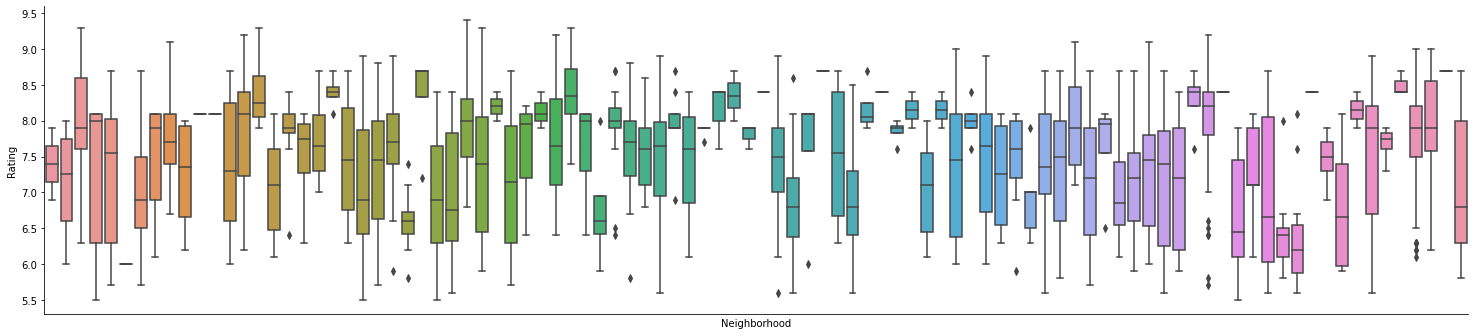

In [4]:
sns.catplot(x="Neighborhood", y="Rating", data=toronto_venues, height=5, aspect=5, kind = "box").set(xticks=[])

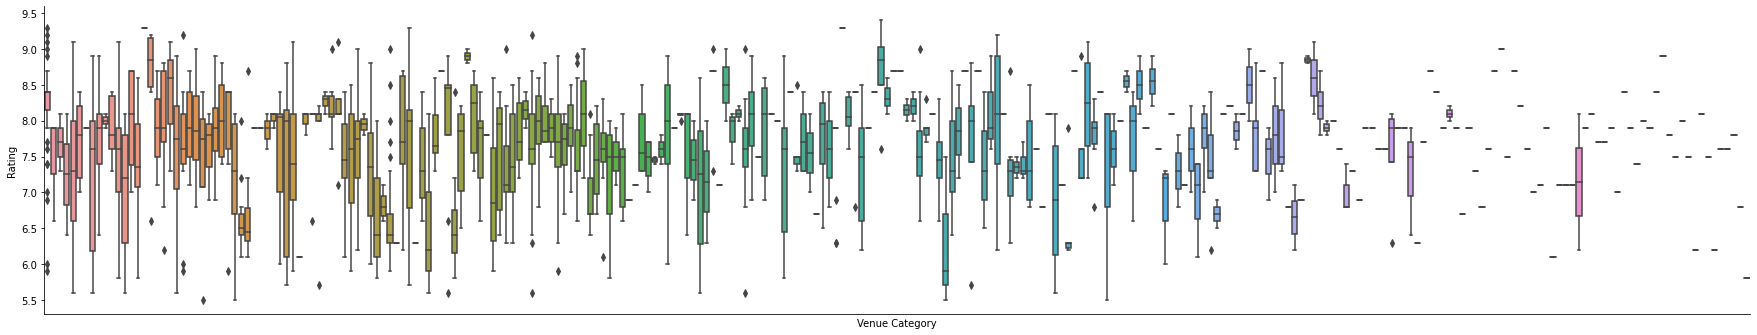

In [5]:
sns.catplot(x="Venue Category", y="Rating", data=toronto_venues, height=5, aspect=5, kind = "box").set(xticks=[])

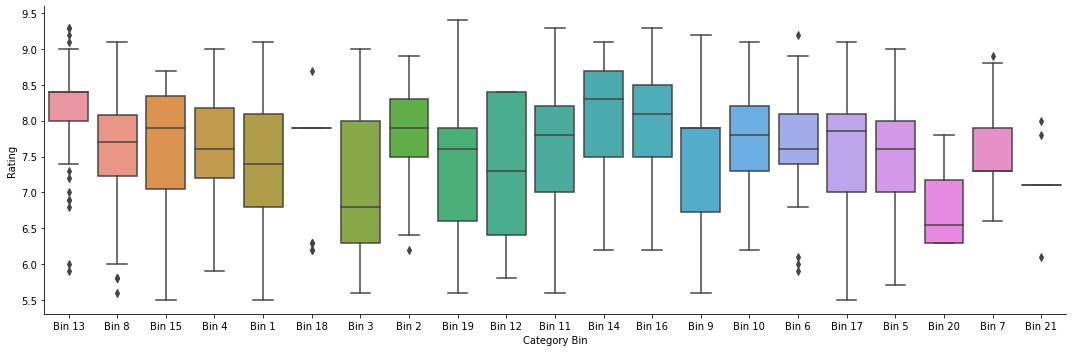

In [6]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues, height=5, aspect=3, kind = "box")

<h2>Part 3: Model development</h2>

<h4>Clustering the neighborhoods based on their similarity </h4>

In [13]:
# Function to get a dataframe for the most common venues for each neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [9]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Category Bin']], prefix="", prefix_sep="")
# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

# Get the most common venues for each Toronto neighborhood
num_top_venues = 3

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [10]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Bin 1,Bin 6,Bin 11
1,"Alderwood, Long Branch",Bin 3,Bin 1,Bin 11
2,"Bathurst Manor, Wilson Heights, Downsview North",Bin 9,Bin 3,Bin 17
3,Bayview Village,Bin 5,Bin 19,Bin 1
4,"Bedford Park, Lawrence Manor East",Bin 1,Bin 8,Bin 3


In [11]:
# Set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
# Create new dataframes that includes the cluster and top 10 venues
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_venues
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = toronto_merged.dropna()

In [12]:
toronto_merged.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Id,Venue Latitude,Venue Longitude,Venue Category,Rating,Category Bin,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,4e8d9dcdd5fbbbb6b3003c7b,43.751976,-79.332140,Park,6.9,Bin 13,0,Bin 13,Bin 8,Bin 9
1,Parkwoods,43.753259,-79.329656,Variety Store,4cb11e2075ebb60cd1c4caad,43.751974,-79.333114,Food & Drink Shop,7.9,Bin 8,0,Bin 13,Bin 8,Bin 9
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,4c633acb86b6be9a61268e34,43.723481,-79.315635,Hockey Arena,7.3,Bin 15,1,Bin 4,Bin 1,Bin 3


<h4>Now we have clustered the neighborhoods based on the most common type of venue </h4>

In [13]:
toronto_mini = toronto_merged[["Cluster Labels", "Venue"]]
toronto_mini.groupby('Cluster Labels').count()

,Venue
Cluster Labels,
0,35
1,216
2,6
3,23
4,15
5,1416


<AxesSubplot:xlabel='Cluster Labels', ylabel='Rating'>

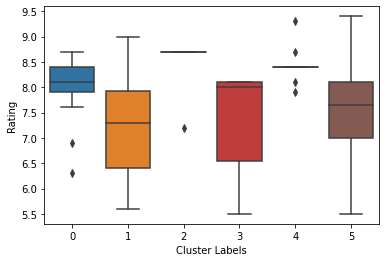

In [14]:
sns.boxplot(x="Cluster Labels", y="Rating", data=toronto_merged)


<h4>We can see a better relationship between cluster and venue rating</4>

In [15]:
toronto_venues = toronto_merged[["Cluster Labels", "Neighborhood", "Neighborhood Latitude", "Neighborhood Longitude", "Venue", "Rating", "Venue Category", "Category Bin","Venue Latitude", "Venue Longitude", "1st Most Common Venue", "3rd Most Common Venue", "1st Most Common Venue" ]].copy()

In [14]:
#Now we have clustered the e neighborhoods and realigned the dataframe
#Fourth 'checkpoint' of the notebook

#toronto_venues.to_csv('toronto_merged.csv')
toronto_venues = pd.read_csv('toronto_merged.csv', index_col=0)

In [15]:
toronto_venues.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Rating,Venue Category,Category Bin,Venue Latitude,Venue Longitude,1st Most Common Venue,3rd Most Common Venue,1st Most Common Venue.1
0,0,Parkwoods,43.753259,-79.329656,Brookbanks Park,6.9,Park,Bin 13,43.751976,-79.332140,Bin 13,Bin 9,Bin 13
1,0,Parkwoods,43.753259,-79.329656,Variety Store,7.9,Food & Drink Shop,Bin 8,43.751974,-79.333114,Bin 13,Bin 9,Bin 13
2,1,Victoria Village,43.725882,-79.315572,Victoria Village Arena,7.3,Hockey Arena,Bin 15,43.723481,-79.315635,Bin 4,Bin 3,Bin 4
3,1,Victoria Village,43.725882,-79.315572,Portugril,6.4,Portuguese Restaurant,Bin 4,43.725819,-79.312785,Bin 4,Bin 3,Bin 4
4,1,Victoria Village,43.725882,-79.315572,Tim Hortons,6.0,Coffee Shop,Bin 1,43.725517,-79.313103,Bin 4,Bin 3,Bin 4


<h4>Obtaining the most common category bins by cluster, just for information purposes </4>

In [16]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Category Bin']], prefix="", prefix_sep="")
# Add neighborhood column back to dataframe
toronto_onehot['Cluster Labels'] = toronto_venues['Cluster Labels'] 
# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Cluster Labels').mean().reset_index()

# Get the most common venues for each Toronto neighborhood
num_top_venues = 3

indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Cluster Labels'] = toronto_grouped['Cluster Labels']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [17]:
neighborhoods_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,Bin 13,Bin 9,Bin 14
1,1,Bin 3,Bin 9,Bin 1
2,2,Bin 14,Bin 4,Bin 9
3,3,Bin 17,Bin 1,Bin 5
4,4,Bin 13,Bin 14,Bin 15
5,5,Bin 1,Bin 17,Bin 8


<h4>Let's separate the clusters into their own dataframe so we can explore the grouping that occurred</h4>

In [19]:
toronto_venues_c1 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 0].copy()
toronto_venues_c2 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 1].copy()
toronto_venues_c3 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 2].copy()
toronto_venues_c4 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 3].copy()
toronto_venues_c5 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 4].copy()
toronto_venues_c6 = toronto_venues.loc[toronto_venues["Cluster Labels"] == 5].copy()

In [20]:
list_clusters = [toronto_venues_c1, toronto_venues_c2, toronto_venues_c3, toronto_venues_c4, toronto_venues_c5, toronto_venues_c6]

In [22]:
for cluster in list_clusters:
    clust_name = cluster['Cluster Labels'].unique()
    clust_name = clust_name[0]
    print("Cluster "+ str(clust_name+1)+":")
    print('There are {} neighborhoods.'.format(len(cluster['Neighborhood'].unique())))
    print('There are {} category bins.'.format(len(cluster['Category Bin'].unique())))
    print('There are {} venues.'.format(len(cluster['Venue'].unique())))
    print('There are {} unique categories.'.format(len(cluster['Venue Category'].unique())))
    #for neighborhood in cluster["Neighborhood"].unique():
        #print (neighborhood)
    
    #for bin in cluster['Category Bin'].unique():
        #print (bin)  
    print("\n")

Cluster 1:
There are 11 neighborhoods.
There are 12 category bins.
There are 35 venues.
There are 21 unique categories.


Cluster 2:
There are 22 neighborhoods.
There are 19 category bins.
There are 167 venues.
There are 77 unique categories.


Cluster 3:
There are 3 neighborhoods.
There are 2 category bins.
There are 6 venues.
There are 5 unique categories.


Cluster 4:
There are 3 neighborhoods.
There are 5 category bins.
There are 21 venues.
There are 16 unique categories.


Cluster 5:
There are 6 neighborhoods.
There are 3 category bins.
There are 15 venues.
There are 8 unique categories.


Cluster 6:
There are 51 neighborhoods.
There are 21 category bins.
There are 1190 venues.
There are 240 unique categories.




In [23]:
# Getting the geospatial data for Toronto

address = 'Toronto, ON'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


<h4>For cluster number one:</h4>

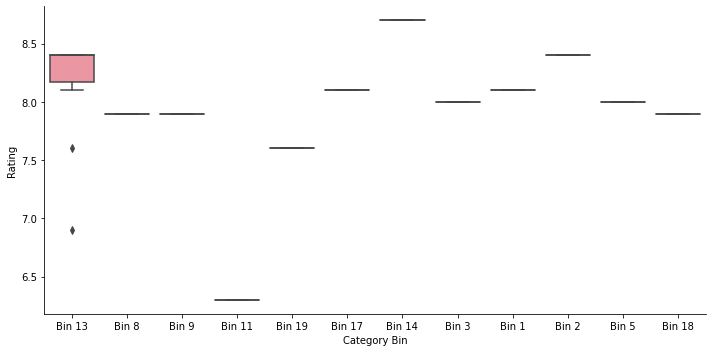

In [24]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c1, height = 5, aspect = 2, kind = "box")

In [25]:
toronto_mini = toronto_venues_c1[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 1,1
Bin 11,1
Bin 13,14
Bin 14,3
Bin 17,2
Bin 18,2
Bin 19,3
Bin 2,1
Bin 3,1


In [26]:
# Creating a map of Toronto with the neighborhoods marked

# Create map using latitude and longitude values
map_c1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c1['Neighborhood Latitude'], toronto_venues_c1['Neighborhood Longitude'], toronto_venues_c1['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c1)  
    
map_c1

<h4>For cluster number two:</h4>

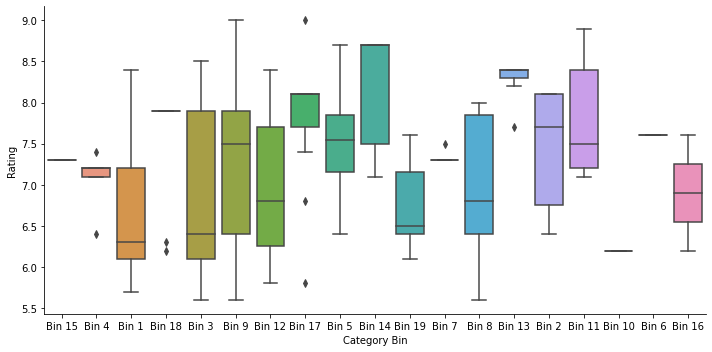

In [27]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c2, height = 5, aspect = 2, kind = "box")

In [28]:
toronto_mini = toronto_venues_c2[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 1,21
Bin 10,1
Bin 11,5
Bin 12,11
Bin 13,7
Bin 14,11
Bin 15,1
Bin 16,2
Bin 17,11


In [29]:
# Create map using latitude and longitude values
map_c2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c2['Neighborhood Latitude'], toronto_venues_c2['Neighborhood Longitude'], toronto_venues_c2['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c2)  
    
map_c2

<h4>For cluster number three:</h4>

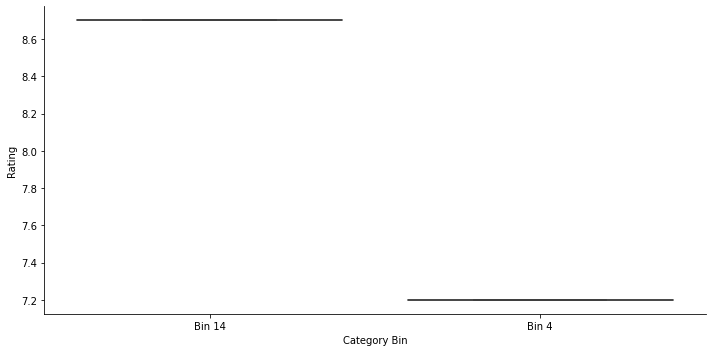

In [30]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c3, height = 5, aspect = 2, kind = "box")

In [30]:
toronto_mini = toronto_venues_c3[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 14,5
Bin 4,1


In [31]:
# Create map using latitude and longitude values
map_c3 = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c3['Neighborhood Latitude'], toronto_venues_c3['Neighborhood Longitude'], toronto_venues_c3['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c3)  
    
map_c3

<h4>For cluster number four:</h4>

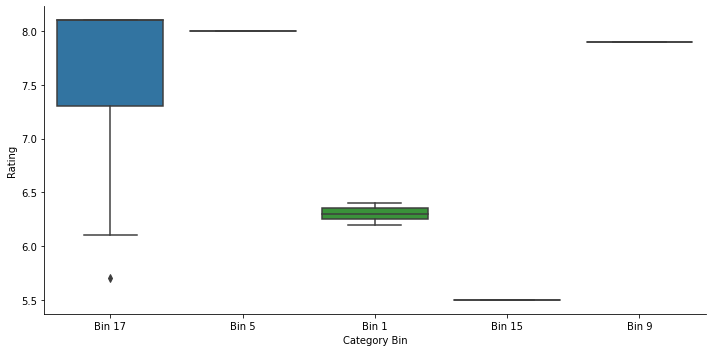

In [32]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c4, height = 5, aspect = 2, kind = "box")

In [33]:
toronto_mini = toronto_venues_c4[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 1,2
Bin 15,1
Bin 17,17
Bin 5,2
Bin 9,1


In [34]:
toronto_venues_c4.groupby('Venue Category').count() 

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Rating,Category Bin,Venue Latitude,Venue Longitude,1st Most Common Venue,3rd Most Common Venue,1st Most Common Venue.1
Venue Category,,,,,,,,,,,,
Accessories Store,1,1,1,1,1,1,1,1,1,1,1,1
Athletics & Sports,1,1,1,1,1,1,1,1,1,1,1,1
Boutique,1,1,1,1,1,1,1,1,1,1,1,1
Chinese Restaurant,1,1,1,1,1,1,1,1,1,1,1,1
Clothing Store,3,3,3,3,3,3,3,3,3,3,3,3
Coffee Shop,2,2,2,2,2,2,2,2,2,2,2,2
Convenience Store,1,1,1,1,1,1,1,1,1,1,1,1
Department Store,1,1,1,1,1,1,1,1,1,1,1,1
Discount Store,2,2,2,2,2,2,2,2,2,2,2,2


In [35]:
# Create map using latitude and longitude values
map_c4 = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c4['Neighborhood Latitude'], toronto_venues_c4['Neighborhood Longitude'], toronto_venues_c4['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c4)  
    
map_c4

<h4>For cluster number five:</h4>

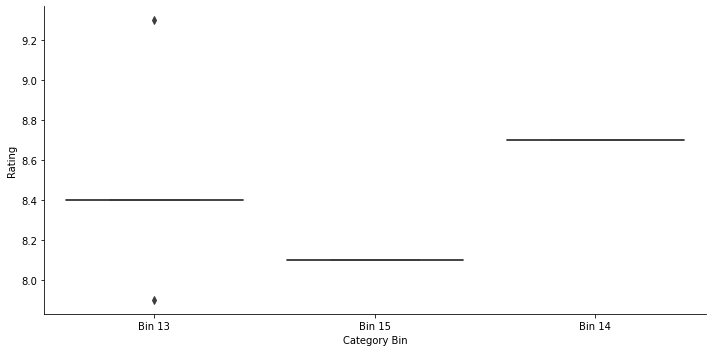

In [36]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c5, height = 5, aspect = 2, kind = "box")

In [37]:
toronto_mini = toronto_venues_c5[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 13,13
Bin 14,1
Bin 15,1


In [38]:
# Create map using latitude and longitude values
map_c5 = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c5['Neighborhood Latitude'], toronto_venues_c5['Neighborhood Longitude'], toronto_venues_c5['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c5)  
    
map_c5

<h4>For cluster number six:</h4>

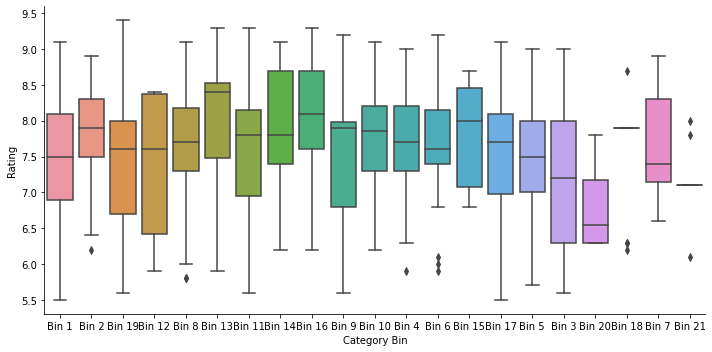

In [39]:
sns.catplot(x="Category Bin", y="Rating", data=toronto_venues_c6, height = 5, aspect = 2, kind = "box")

In [40]:
toronto_mini = toronto_venues_c6[["Category Bin", "Venue"]]
toronto_mini.groupby('Category Bin').count()  

,Venue
Category Bin,
Bin 1,246
Bin 10,40
Bin 11,111
Bin 12,30
Bin 13,36
Bin 14,53
Bin 15,12
Bin 16,17
Bin 17,156


In [41]:
toronto_venues_c6.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Rating,Venue Category,Category Bin,Venue Latitude,Venue Longitude,1st Most Common Venue,3rd Most Common Venue,1st Most Common Venue.1
8,5,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,8.9,Coffee Shop,Bin 1,43.653559,-79.361809,Bin 1,Bin 9,Bin 1
9,5,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,8.9,Bakery,Bin 2,43.653447,-79.362017,Bin 1,Bin 9,Bin 1
10,5,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,8.1,Distribution Center,Bin 19,43.653249,-79.358008,Bin 1,Bin 9,Bin 1
11,5,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,7.6,Spa,Bin 12,43.654735,-79.359874,Bin 1,Bin 9,Bin 1
12,5,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,8.6,Restaurant,Bin 8,43.656369,-79.356980,Bin 1,Bin 9,Bin 1


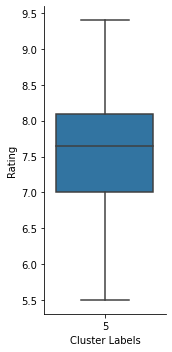

In [42]:
sns.catplot(x="Cluster Labels", y="Rating", data=toronto_venues_c6, height = 5, aspect = .5, kind = "box")

In [43]:
# Create map using latitude and longitude values
map_c6 = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(toronto_venues_c6['Neighborhood Latitude'], toronto_venues_c6['Neighborhood Longitude'], toronto_venues_c6['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_c6)  
    
map_c6